In [1]:
!pip install -q arxiv
!pip install -q pymupdf
!pip install -q sentence-transformers
!pip install -q faiss-cpu
!pip install -q evaluate
!pip install -q datasets
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q trl
!pip install -q einops
!pip install -q langchain
!pip install -q langchain-community

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:

In [2]:
import os
import re
import arxiv
import fitz  # PyMuPDF
import faiss
import numpy as np
from datasets import Dataset
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings


2025-09-13 16:59:43.004266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757782783.336748      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757782783.432381      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# data collection
def get_cvpr_papers(max_results=6):
    search = arxiv.Search(
        query="cat:cs.CV", 
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )
    papers = []
    for result in search.results():
        papers.append({
            'title': result.title,
            'authors': [author.name for author in result.authors],
            'summary': result.summary,
            'published': result.published,
            'pdf_url': result.pdf_url
        })
    return papers

def download_and_extract_text(papers):
    
    for paper in papers:
        try:
            client = arxiv.Client()
            paper_obj = next(client.results(arxiv.Search(id_list=[paper['pdf_url'].split('/')[-1]])))
            pdf_path = paper_obj.download_pdf()
            doc = fitz.open(pdf_path)
            full_text = ""
            for page in doc:
                full_text += page.get_text()
            paper['full_text'] = full_text
        except Exception as e:
            print(f"Failed to process {paper['title']}: {e}")
            paper['full_text'] = ""
    return papers

# preprocessing
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'-\n', '', text)    
    text = text.strip()
    return text

def preprocess_papers(papers):
    for paper in papers:
        paper['full_text'] = clean_text(paper['full_text'])
    return papers

# vector store creation
def create_vector_store(papers, model_name="all-MiniLM-L6-v2"):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = []
    for paper in papers:
        if paper['full_text']:
            chunks = text_splitter.split_text(paper['full_text'])
            for chunk in chunks:
                docs.append({
                    "content": chunk,
                    "metadata": {
                        "title": paper['title'],
                        "authors": ", ".join(paper['authors']),
                        "published": paper['published']
                    }
                })

    # Use LangChain's document structure
    from langchain.docstore.document import Document
    langchain_docs = [Document(page_content=doc['content'], metadata=doc['metadata']) for doc in docs]


    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    vector_store = FAISS.from_documents(langchain_docs, embeddings)
    return vector_store


if __name__ == '__main__':
    # Fetch and process papers
    cvpr_papers = get_cvpr_papers(max_results=10) 
    cvpr_papers_with_text = download_and_extract_text(cvpr_papers)
    preprocessed_papers = preprocess_papers(cvpr_papers_with_text)

    # Create and save the vector store
    vector_store = create_vector_store(preprocessed_papers)
    vector_store.save_local("faiss_index_cvpr")

    print("Vector store created successfully.")

/tmp/ipykernel_36/4227283190.py:12: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():
/tmp/ipykernel_36/4227283190.py:84: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector store created successfully.


In [4]:
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import pandas as pd
import os

# disable wandb_api
os.environ["WANDB_DISABLED"] = "true"


# a dummy 'preprocessed_papers' object is created if it doesn't exist.
if 'preprocessed_papers' not in locals():
    print("Creating dummy data for 'preprocessed_papers' to ensure code runs.")
    preprocessed_papers = [
        {
            'title': 'Attention Is All You Need',
            'summary': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks... We propose a new simple network architecture, the Transformer, based solely on attention mechanisms.',
        },
        {
            'title': 'Generative Adversarial Nets',
            'summary': 'We propose a new framework for estimating generative models via an adversarial process... a generative model G that captures the data distribution, and a discriminative model D that estimates the probability that a sample came from the training data rather than G.',
        }
    ]

# Dataset Preparation (Synthetic Q&A) 
def create_synthetic_dataset(papers):
    prompts = []
    for paper in papers:
        if paper['summary']:
            methodology_prompt = f"### Question: What is the methodology proposed in the paper titled '{paper['title']}'?\n### Answer: {paper['summary']}"
            contribution_prompt = f"### Question: What are the main contributions of '{paper['title']}'?\n### Answer: {paper['summary']}"
            prompts.append(methodology_prompt)
            prompts.append(contribution_prompt)
    return Dataset.from_dict({"text": prompts})

# model configuration
model_id = "Qwen/Qwen2-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# fine tuning with transformers.Trainer
if __name__ == '__main__':
    synthetic_dataset = create_synthetic_dataset(preprocessed_papers)

    tokenized_dataset = synthetic_dataset.map(
        lambda examples: tokenizer(examples["text"], truncation=True, max_length=512, padding=False),
        batched=True
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    model.config.use_cache = False
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)

    training_args = TrainingArguments(
        output_dir="./qwen2-cvpr-finetuned",
        num_train_epochs=3,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        logging_dir="./logs",
        logging_steps=10,
        learning_rate=2e-4,
        save_strategy="epoch",
        fp16=True,
        report_to="none",
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Start the training process
    trainer.train()

    # Save the fine-tuned model adapters
    trainer.save_model("./qwen2-cvpr-finetuned")
    tokenizer.save_pretrained("./qwen2-cvpr-finetuned")
    print("\nFine-tuning complete and model adapters saved successfully.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

/tmp/ipykernel_36/552575293.py:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,2.471700


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



Fine-tuning complete and model adapters saved successfully.


In [6]:
# merge fine tuned adapters with base model
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os

# configuration
base_model_id = "Qwen/Qwen2-1.5B-Instruct"
adapter_path = "./qwen2-cvpr-finetuned"
merged_model_path = "./qwen2-cvpr-merged" 

print("Loading base model...")
# Load the base model with the same precision as used for training
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)

print("Loading PEFT adapters...")
# Load the PEFT model (base model + adapters)
model = PeftModel.from_pretrained(base_model, adapter_path)

print("Merging model and adapters...")
# Merge the adapters into the base model
model = model.merge_and_unload()
print("Merge complete.")

print(f"Saving merged model to {merged_model_path}...")
# Save the merged model and its tokenizer
model.save_pretrained(merged_model_path)
tokenizer = AutoTokenizer.from_pretrained(adapter_path)
tokenizer.save_pretrained(merged_model_path)

print("\nModel merged and saved successfully!")
print(f"You can now download the '{merged_model_path}' directory and use it with Ollama.")

# List files to confirm
print("\nFiles in the new merged model directory:")
for dirname, _, filenames in os.walk(merged_model_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Loading base model...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading PEFT adapters...
Merging model and adapters...
Merge complete.
Saving merged model to ./qwen2-cvpr-merged...

Model merged and saved successfully!
You can now download the './qwen2-cvpr-merged' directory and use it with Ollama.

Files in the new merged model directory:
./qwen2-cvpr-merged/generation_config.json
./qwen2-cvpr-merged/tokenizer.json
./qwen2-cvpr-merged/special_tokens_map.json
./qwen2-cvpr-merged/chat_template.jinja
./qwen2-cvpr-merged/model.safetensors
./qwen2-cvpr-merged/merges.txt
./qwen2-cvpr-merged/tokenizer_config.json
./qwen2-cvpr-merged/config.json
./qwen2-cvpr-merged/vocab.json
./qwen2-cvpr-merged/added_tokens.json


In [5]:
import os
import zipfile

folders = ["faiss_index_cvpr", "qwen2-cvpr-finetuned"]
zip_path = "/kaggle/working/cvpr_folders.zip"

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in folders:
        for root, _, files in os.walk(folder):
            for file in files:
                filepath = os.path.join(root, file)
                arcname = os.path.relpath(filepath, "/kaggle/working")
                zipf.write(filepath, arcname)

print(f"Created zip file at: {zip_path}")


Created zip file at: /kaggle/working/cvpr_folders.zip


In [7]:
import shutil
# config
folder_to_zip = 'qwen2-cvpr-merged'
output_zip_filename = 'qwen2-cvpr-merged' # The .zip extension will be added automatically


if os.path.isdir(folder_to_zip):
    print(f"Zipping the directory: '{folder_to_zip}'...")
    shutil.make_archive(
        base_name=output_zip_filename,  
        format='zip',                   
        root_dir=folder_to_zip          
    )

    print(f"\nSuccessfully created '{output_zip_filename}.zip'")
    print("You can now find this file in the file explorer panel on the left and download it.")
else:
    print(f"Error: The directory '{folder_to_zip}' does not exist.")
    print("Please make sure you have run the model merging script successfully.")

Zipping the directory: 'qwen2-cvpr-merged'...

Successfully created 'qwen2-cvpr-merged.zip'
You can now find this file in the file explorer panel on the left and download it.


In [27]:
# RAG pipeline with local model in Kaggle
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

print("Loading RAG components with a local model...")

# Load FAISS vector score
embeddings_model_name = "all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)
faiss_index_path = "/kaggle/working/faiss_index_cvpr"
vector_store = FAISS.load_local(
    faiss_index_path,
    embeddings,
    allow_dangerous_deserialization=True
)
print(f"FAISS index loaded successfully from: {faiss_index_path}")

# Load local fine tuned model and tokenizer
local_model_path = "/kaggle/working/qwen2-cvpr-merged"
print(f"Loading tokenizer from: {local_model_path}")
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
print(f"Loading model from: {local_model_path}")
model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
print("Model loaded successfully onto the GPU.")

# Transformers pipeline for text generation
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.1,
    top_p=0.95
)
local_llm = HuggingFacePipeline(pipeline=pipe)
print("LangChain LLM wrapper created successfully.")

prompt_template = """Context: {context}

Question: {question}

Answer:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

# create RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=local_llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
print("RAG chain created successfully with simplified prompt.")

# Querying the RAG pipeline
if __name__ == '__main__':
    query = "What is the name of the new benchmark for measuring epistemic humility in MLLMs?"
    print(f"\nTesting RAG chain with query: '{query}'")
    try:
        result = qa_chain({"query": query})
        print("\n--- Test RAG Response ---")
        print(result['result'])
    except Exception as e:
        print(f"\nAn error occurred while querying the RAG chain: {e}")

Loading RAG components with a local model...
FAISS index loaded successfully from: /kaggle/working/faiss_index_cvpr
Loading tokenizer from: /kaggle/working/qwen2-cvpr-merged
Loading model from: /kaggle/working/qwen2-cvpr-merged


Device set to use cuda:0


Model loaded successfully onto the GPU.
LangChain LLM wrapper created successfully.
RAG chain created successfully with simplified prompt.

Testing RAG chain with query: 'What is the name of the new benchmark for measuring epistemic humility in MLLMs?'

--- Test RAG Response ---
Context: Finally, we conduct a manual filtering process to refine the questions and options. are named HumbleBench, HumbleBench-E, and HumbleBench-GN, respectively. HumbleBench is the original benchmark. HumbleBench-E and HumbleBench-GN are two stress tests. Specif- ically, HumbleBench-E removes correct non-E answers so the E option, i.e., “None of the above”, is the only correct answer for the entire dataset. HumbleBench-GN replaces all images with Gaus- sian noise so, again, only the E option is correct. Accuracy (%) is reported as the primary metric throughout the experiments. 3.1 Results on HumbleBench Overall Accuracy Well Above Random Guess But Far From Perfect. As shown in Table 3, HumbleBench presents a

In [28]:

from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

print("Initializing agent with the local LLM...")


tools = [
    Tool(
        name="CVPR Research Paper QA System",
        func=qa_chain, # The function of the tool is our RAG chain
        description=(
            "Use this tool to answer specific questions about computer vision research papers from CVPR. "
            "The input must be a complete, well-formed question."
        )
    )
]

agent = initialize_agent(
    tools,
    local_llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True, # Set to True to see the agent's thought process
    handle_parsing_errors=True # Helps with occasional model formatting issues
)
print("Agent initialized successfully.")


if __name__ == '__main__':
    agent_query = (
        "Find a paper on generative models and explain its core methodology based on the provided context."
    )
    print(f"\nExecuting agent with query: '{agent_query}'")
    try:
        # The agent's 'run' method invokes the thought-action-observation loop
        response = agent.run(agent_query)
        print("\n--- Agent's Final Answer ---")
        print(response)
    except Exception as e:
        print(f"\nAn error occurred while running the agent: {e}")

Initializing agent with the local LLM...
Agent initialized successfully.

Executing agent with query: 'Find a paper on generative models and explain its core methodology based on the provided context.'


> Entering new AgentExecutor chain...
Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

CVPR Research Paper QA System(inputs: Union[dict[str, Any], Any], return_only_outputs: bool = False, callbacks: Union[list[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None, *, tags: Optional[list[str]] = None, metadata: Optional[dict[str, Any]] = None, run_name: Optional[str] = None, include_run_info: bool = False) -> dict[str, typing.Any] - Use this tool to answer specific questions about computer vision research papers from CVPR. The input must be a complete, well-formed question.

Use the following format:

Question

Building author collaboration graph...
Graph created with 76 authors and 329 collaborations.


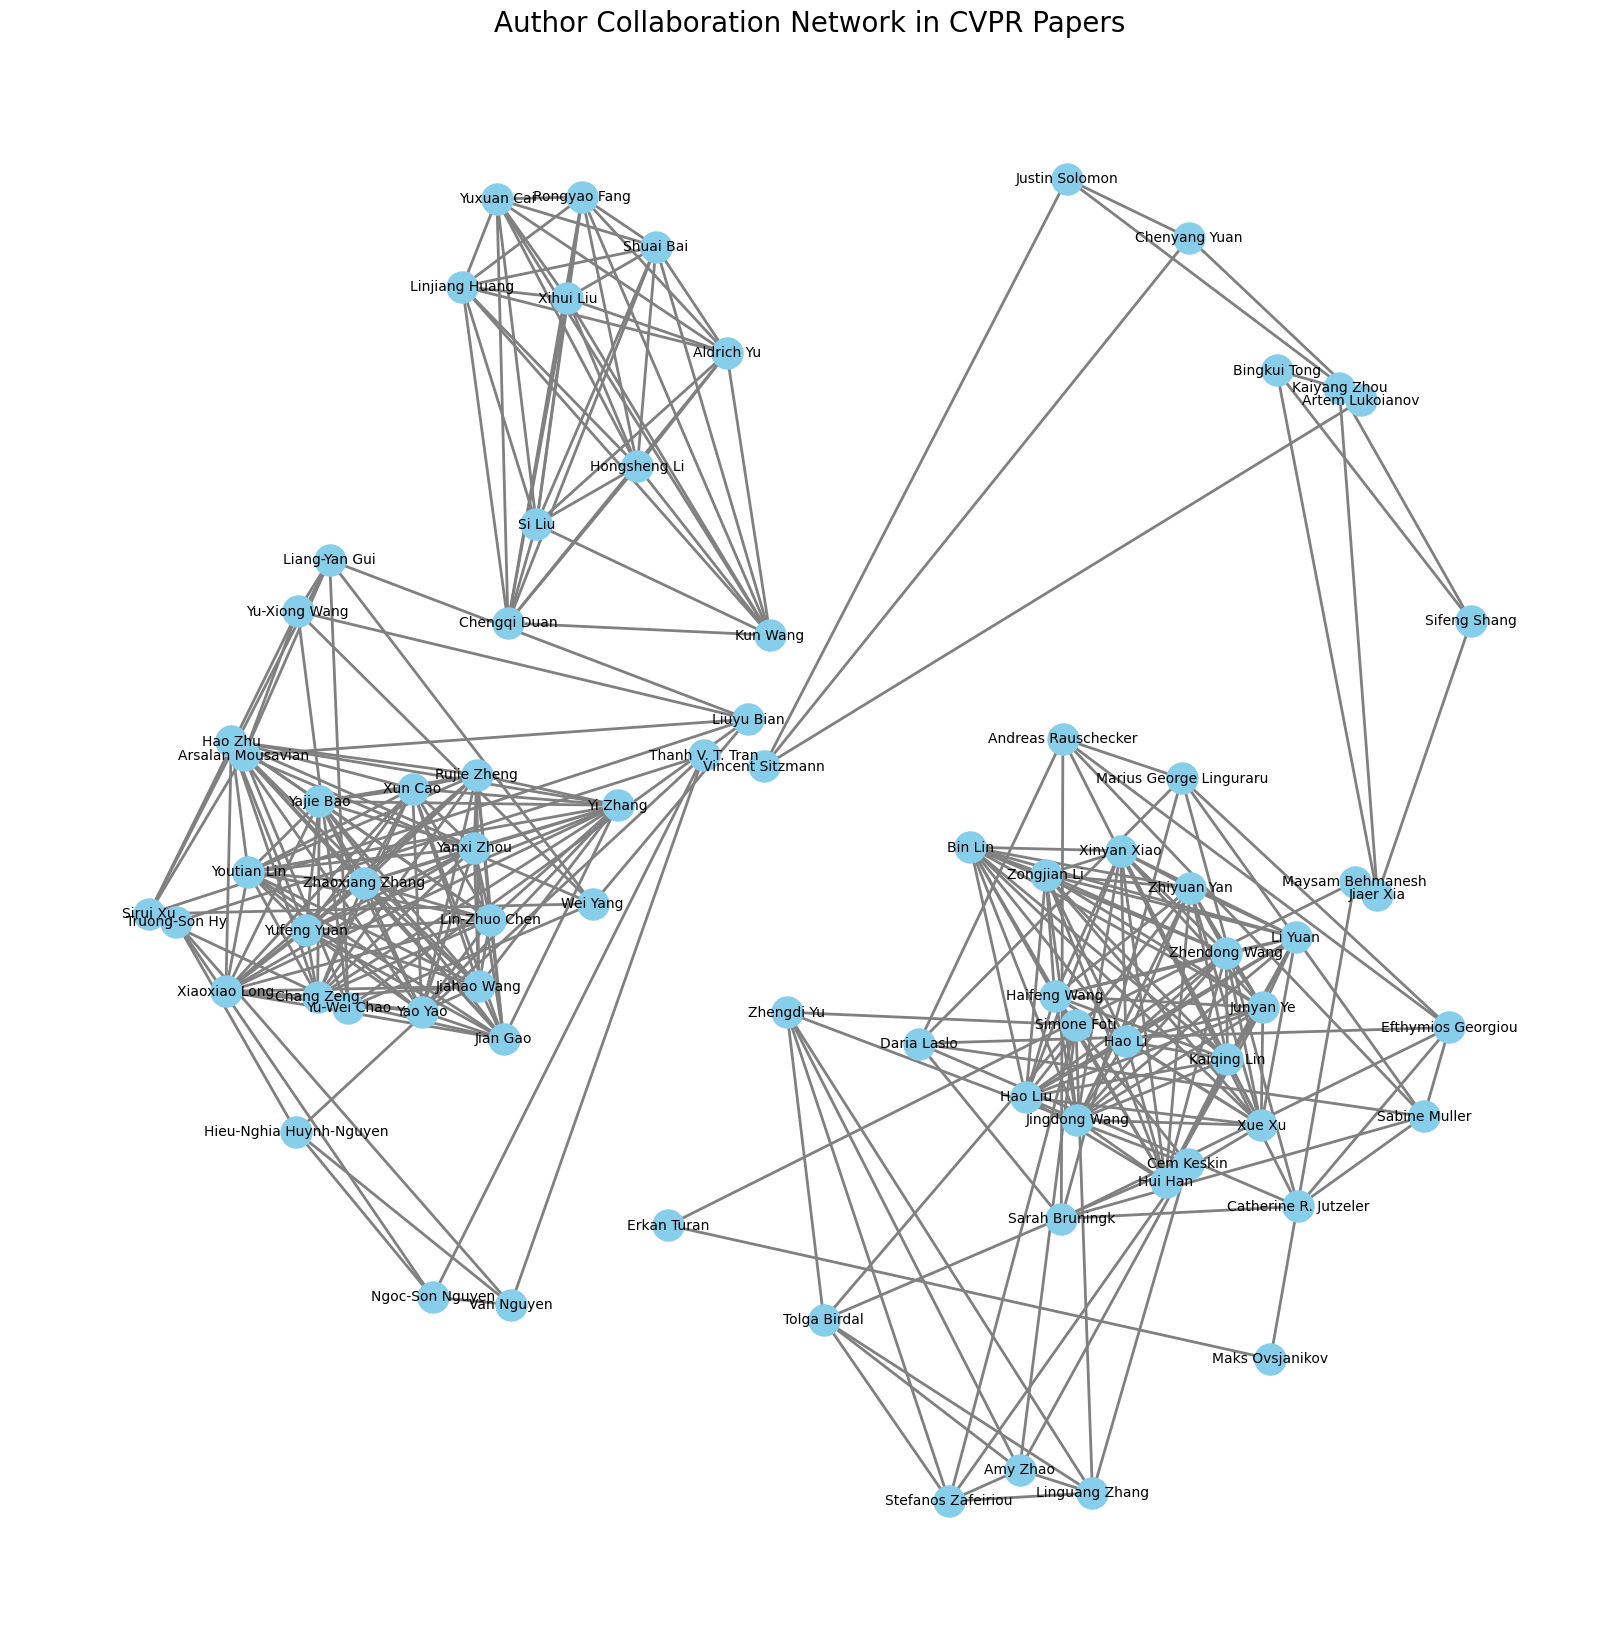

In [22]:
# GRAPH database visualization
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Adding a check to prevent errors if the variable is missing.
if 'preprocessed_papers' not in locals() or not preprocessed_papers:
    print("Warning: 'preprocessed_papers' not found. Creating dummy data for visualization.")
    preprocessed_papers = [
        {'authors': ['Author A', 'Author B', 'Author C']},
        {'authors': ['Author C', 'Author D']},
        {'authors': ['Author A', 'Author C', 'Author E']},
        {'authors': ['Author B', 'Author E']}
    ]


# Collaboration Graph
def build_collaboration_graph(papers):
    """Builds a collaboration graph of authors."""
    G = nx.Graph()
    for paper in papers:
        authors = paper.get('authors', [])
        if len(authors) > 1:
            # Create edges between all pairs of co-authors
            for author1, author2 in combinations(authors, 2):
                if G.has_edge(author1, author2):
                    # Increase the weight for each additional collaboration
                    G[author1][author2]['weight'] += 1
                else:
                    # Add a new edge with a starting weight of 1
                    G.add_edge(author1, author2, weight=1)
    return G


# Visualization
if __name__ == '__main__':
    print("Building author collaboration graph...")
    collaboration_graph = build_collaboration_graph(preprocessed_papers)
    print(f"Graph created with {collaboration_graph.number_of_nodes()} authors and {collaboration_graph.number_of_edges()} collaborations.")

    if collaboration_graph.number_of_nodes() > 0:
        plt.figure(figsize=(16, 16))
        pos = nx.spring_layout(collaboration_graph, k=0.8, iterations=50)
        weights = [collaboration_graph[u][v]['weight'] for u, v in collaboration_graph.edges()]

        nx.draw(
            collaboration_graph, pos, with_labels=True, node_color='skyblue',
            node_size=500, width=[w * 2 for w in weights], font_size=10,
            font_color='black', edge_color='gray'
        )
        plt.title("Author Collaboration Network in CVPR Papers", size=20)
        plt.show()
    else:
        print("Graph is empty, cannot display.")

In [24]:
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [29]:
# Evaluation Metrics

import pandas as pd
from evaluate import load
from sentence_transformers import SentenceTransformer, util
import numpy as np

print("Starting RAG pipeline evaluation with the simplified prompt...")

# a small but accurate evaluation dataset is created through preprocessed papers
eval_dataset = [
    {
        "question": "What is the name of the framework proposed for graph alignment and what does it stand for?",
        "ground_truth_answer": "The paper introduces GADL, which stands for Graph Alignment with Dual-pass encoder and Latent space communication.",
        "ground_truth_context_substring": "In this paper, we introduce GADL—Graph Alignment with Dual-pass encoder and Latent space communication"
    },
    {
        "question": "What are the two critical limitations of existing unsupervised graph alignment methods?",
        "ground_truth_answer": "They suffer from the degradation of node distinctiveness due to GNN oversmoothing and the misalignment of latent spaces across different graphs.",
        "ground_truth_context_substring": "suffer from two critical limitations: the degradation of node distinctiveness due to oversmoothing in GNN-based embeddings, and the misalignment of latent spaces"
    },
    {
        "question": "What is the name of the new benchmark for measuring epistemic humility in MLLMs?",
        "ground_truth_answer": "The paper presents HumbleBench, a new hallucination benchmark designed to evaluate an MLLM's ability to reject plausible but incorrect answers.",
        "ground_truth_context_substring": "We present HumbleBench, a new hallucination benchmark designed to evaluate MLLMs' ability to reject plausible but incorrect answers"
    },
    {
        "question": "What type of model does the 'Mechanistic Learning' paper propose for predicting brain tumor growth?",
        "ground_truth_answer": "The paper proposes a hybrid mechanistic learning framework that combines a mathematical tumor growth model with a guided denoising diffusion implicit model (DDIM).",
        "ground_truth_context_substring": "propose a hybrid mechanistic learning framework that combines a mathematical tumor growth model with a guided denoising diffusion implicit model (DDIM)"
    },
    {
        "question": "What is the key innovation of the DiFlow-TTS model for speech synthesis?",
        "ground_truth_answer": "DiFlow-TTS is the first model to explore a purely Discrete Flow Matching approach for speech synthesis, unlike previous methods that used continuous spaces.",
        "ground_truth_context_substring": "we introduce DiFlow-TTS, which, to the best of our knowledge, is the first model to explore purely Discrete Flow Matching for speech synthesis"
    },
    {
        "question": "What are the two primary contributions of the paper on million-scale text-to-image reasoning?",
        "ground_truth_answer": "The paper introduces FLUX-Reason-6M, a massive dataset for reasoning, and PRISM-Bench, a comprehensive evaluation benchmark for text-to-image models.",
        "ground_truth_context_substring": "To address this challenge, We introduce FLUX-Reason-6M and PRISM-Bench"
    }
]

print(f"Evaluation dataset created with {len(eval_dataset)} examples.")

results = []
retriever = vector_store.as_retriever(search_kwargs={'k': 5})

for item in eval_dataset:
    question = item["question"]
    ground_truth_context_sub = item["ground_truth_context_substring"]
    retrieved_docs = retriever.get_relevant_documents(question)
    retrieved_contexts = [doc.page_content for doc in retrieved_docs]
    hit = any(ground_truth_context_sub.lower() in ctx.lower() for ctx in retrieved_contexts)
    rr = 0.0
    for i, ctx in enumerate(retrieved_contexts):
        if ground_truth_context_sub.lower() in ctx.lower():
            rr = 1 / (i + 1)
            break
    response = qa_chain({"query": question})
    generated_answer = response['result']
    results.append({
        "question": question,
        "generated_answer": generated_answer,
        "retrieved_contexts": retrieved_contexts,
        "hit": hit,
        "rr": rr
    })

results_df = pd.DataFrame(results)
print("Evaluation loop complete.")

# calculate and report metrics
print("\n--- Evaluation Results ---")

hit_rate = results_df['hit'].mean()
mrr = results_df['rr'].mean()

print(f"\n--- Retriever Performance ---")
print(f"Hit Rate (Top 5): {hit_rate:.2%}")
print("  => What percentage of the time was the correct context found in the top 5 retrieved documents?")
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print("  => On average, how high up was the correct document in the retrieved list? (Closer to 1 is better)")
rouge = load('rouge')
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
ground_truth_answers = [item["ground_truth_answer"] for item in eval_dataset]
generated_answers = results_df['generated_answer'].tolist()
rouge_scores = rouge.compute(predictions=generated_answers, references=ground_truth_answers)
gt_embeddings = semantic_model.encode(ground_truth_answers, convert_to_tensor=True)
gen_embeddings = semantic_model.encode(generated_answers, convert_to_tensor=True)
cosine_scores = util.cos_sim(gt_embeddings, gen_embeddings)
mean_semantic_similarity = np.diag(cosine_scores.cpu()).mean()

print(f"\n--- Generator Performance ---")
print(f"ROUGE-L Score: {rouge_scores['rougeL']:.4f}")
print("  => Measures the longest common subsequence between generated and ground truth answers (word overlap).")
print(f"Mean Semantic Similarity: {mean_semantic_similarity:.4f}")
print("  => Measures if the *meaning* of the generated answer is close to the ground truth (closer to 1 is better).")
print("\n--- Detailed Per-Question Results ---")
for index, row in results_df.iterrows():
    print(f"\nQuestion: {row['question']}")
    print(f"  Ground Truth: {ground_truth_answers[index]}")
    print(f"  Generated: {row['generated_answer']}")
    print(f"  Context Hit: {'Yes' if row['hit'] else 'No'}")
    print(f"  Reciprocal Rank: {row['rr']:.2f}")

Starting RAG pipeline evaluation with the simplified prompt...
Evaluation dataset created with 6 examples.
Evaluation loop complete.

--- Evaluation Results ---

--- Retriever Performance ---
Hit Rate (Top 5): 50.00%
  => What percentage of the time was the correct context found in the top 5 retrieved documents?
Mean Reciprocal Rank (MRR): 0.1583
  => On average, how high up was the correct document in the retrieved list? (Closer to 1 is better)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


--- Generator Performance ---
ROUGE-L Score: 0.0350
  => Measures the longest common subsequence between generated and ground truth answers (word overlap).
Mean Semantic Similarity: 0.5759
  => Measures if the *meaning* of the generated answer is close to the ground truth (closer to 1 is better).

--- Detailed Per-Question Results ---

Question: What is the name of the framework proposed for graph alignment and what does it stand for?
  Ground Truth: The paper introduces GADL, which stands for Graph Alignment with Dual-pass encoder and Latent space communication.
  Generated: Context: inconsistencies and challenging alignment scenarios. Additionally, compre- hensive evaluation on vision-language benchmarks using diverse pretrained models shows that our framework effectively generalizes beyond graph domains, enabling unsupervised alignment of vision and language representations. 1 Introduction Graph alignment—also referred to as network alignment or graph matching—is a fundamental prob

In [19]:
# RAG pipeline through OLLAMA hosting through NGROK gateway
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

print("Loading RAG components...")

# Load embeddings and the FAISS index
embeddings_model_name = "all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)
faiss_index_path = "/kaggle/working/faiss_index_cvpr"
vector_store = FAISS.load_local(
    faiss_index_path,
    embeddings,
    allow_dangerous_deserialization=True
)
print(f"FAISS index loaded successfully from: {faiss_index_path}")


# I performed 3 iterations here
# added headers to skip browser warning
NGROK_URL = "https://c4e0965a5df4.ngrok-free.app" # <-- PASTE YOUR NEW NGROK URL

headers = {
    "ngrok-skip-browser-warning": "true",
}

llm = Ollama(
    model="cvpr-rag",
    base_url=NGROK_URL,
    headers=headers,
    temperature=0.1
)
print(f"Connecting to Ollama model 'cvpr-rag' via: {NGROK_URL}")


# prompt chain
prompt_template = """
Use the following pieces of context from research papers to answer the question at the end.
If the context doesn't provide the answer, state that you cannot find the information in the provided documents.
Do not make up information.

Context: {context}

Question: {question}

Helpful Answer:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)
print("RAG chain created successfully.")


# Querying the RAG pipeline
if __name__ == '__main__':
    query = "What are some of the latest advancements in object detection according to the papers?"
    print(f"\nQuerying the RAG chain with: '{query}'")
    try:
        result = qa_chain({"query": query})
        print("\n--- RAG Response ---")
        print(result['result'])
        print("\n--- Source Documents ---")
        for i, doc in enumerate(result['source_documents']):
            print(f"Source {i+1} (from paper: {doc.metadata.get('title', 'N/A')}):")
            print(f"  Content: {doc.page_content[:250]}...\n")
    except Exception as e:
        print(f"\nAn error occurred: {e}")

Loading RAG components...
FAISS index loaded successfully from: /kaggle/working/faiss_index_cvpr
Connecting to Ollama model 'cvpr-rag' via: https://c4e0965a5df4.ngrok-free.app
RAG chain created successfully.

Querying the RAG chain with: 'What are some of the latest advancements in object detection according to the papers?'

An error occurred: Ollama call failed with status code 403. Details: 


In [18]:
query1 = "Summarize text to image reasoning dataset"
print(f"\nQuerying the RAG chain with: '{query1}'")

try:
    # Run the chain
    result1 = qa_chain({"query": query1})

    # Print the results
    print("\n--- RAG Response ---")
    print(result1['result'])
    print("\n--- Source Documents ---")
    for i, doc in enumerate(result1['source_documents']):
        print(f"Source {i+1} (from paper: {doc.metadata.get('title', 'N/A')}):")
        print(f"  Content: {doc.page_content[:250]}...\n")

except Exception as e:
    print(f"\nAn error occurred while querying the RAG chain: {e}")
    print("Please ensure your Ollama service is running and the 'cvpr-rag' model is available.")


Querying the RAG chain with: 'Summarize text to image reasoning dataset'

An error occurred while querying the RAG chain: Ollama call failed with status code 403. Details: 
Please ensure your Ollama service is running and the 'cvpr-rag' model is available.


In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

# Re-instantiate the LLM for the agent
agent_llm = Ollama(model="cvpr-rag", temperature=0)


tools = [
    Tool(
        name="CVPR Research Paper QA System",
        # The function of the tool is to run our RAG chain
        func=qa_chain,
        description=(
            "Use this tool to answer questions about computer vision research papers from CVPR. "
            "The input should be a complete, well-formed question."
        )
    )
]

# Initializing the agent
# We use a ReAct (Reasoning and Acting) agent, which is good for question-answering.
agent = initialize_agent(
    tools,
    agent_llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True, # Set to True to see the agent's thought process
    handle_parsing_errors=True # Helps with occasional model formatting issues
)

print("Agent initialized successfully.")

if __name__ == '__main__':
    agent_query = (
        "Find a paper on generative models and explain its core methodology."
    )
    print(f"\nExecuting agent with query: '{agent_query}'")

    try:
        # The agent's 'run' method invokes the thought-action-observation loop
        response = agent.run(agent_query)
        print("\n--- Agent's Final Answer ---")
        print(response)

    except Exception as e:
        print(f"\nAn error occurred while running the agent: {e}")
        print("Please ensure your Ollama service is running and the 'cvpr-rag' model is available.")

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

if 'preprocessed_papers' not in locals() or not preprocessed_papers:
    print("Warning: 'preprocessed_papers' not found. Creating dummy data for visualization.")
    preprocessed_papers = [
        {'authors': ['Author A', 'Author B', 'Author C']},
        {'authors': ['Author C', 'Author D']},
        {'authors': ['Author A', 'Author C', 'Author E']},
        {'authors': ['Author B', 'Author E']}
    ]

# Collaboration Graph
def build_collaboration_graph(papers):
    """Builds a collaboration graph of authors."""
    G = nx.Graph()
    for paper in papers:
        if len(paper.get('authors', [])) > 1:
            for author1, author2 in combinations(paper['authors'], 2):
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)
    return G

# Visualization
if __name__ == '__main__':
    print("Building author collaboration graph...")
    collaboration_graph = build_collaboration_graph(preprocessed_papers)
    print(f"Graph created with {collaboration_graph.number_of_nodes()} authors and {collaboration_graph.number_of_edges()} collaborations.")

    if collaboration_graph.number_of_nodes() > 0:
        plt.figure(figsize=(16, 16))
        pos = nx.spring_layout(collaboration_graph, k=0.75, iterations=50)
        weights = [collaboration_graph[u][v]['weight'] for u, v in collaboration_graph.edges()]

        nx.draw(
            collaboration_graph,
            pos,
            with_labels=True,
            node_color='skyblue',
            node_size=500,
            width=[w * 2 for w in weights], 
            font_size=10,
            font_color='black',
            edge_color='gray'
        )

        plt.title("Author Collaboration Network in CVPR Papers", size=20)
        plt.show()
    else:
        print("Graph is empty, nothing to display.")